## PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation,Layer,Lambda
from sklearn.metrics import accuracy_score

In [2]:
df= pd.read_csv("/content/forestfires.csv")
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small


In [3]:
df.drop(['month','day'],axis=1,inplace=True)

In [4]:
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,small
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,small
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
dayfri           0
daymon           0
daysat           0
daysun           0
daythu           0
daytue           0
daywed           0
monthapr         0
monthaug         0
monthdec         0
monthfeb         0
monthjan         0
monthjul         0
monthjun         0
monthmar         0
monthmay         0
monthnov         0
monthoct         0
monthsep         0
size_category    0
dtype: int64

In [11]:
df.iloc[:,0:9].describe().T

,count,mean,std,min,25%,50%,75%,max
FFMC,509.0,90.618075,5.555527,18.7,90.2,91.60,92.90,96.20
DMC,509.0,110.235756,63.804112,1.1,62.3,108.30,141.30,291.30
DC,509.0,547.787623,248.196222,7.9,437.7,664.20,713.90,860.60
ISI,509.0,9.023576,4.585083,0.0,6.4,8.40,11.00,56.10
temp,509.0,18.865422,5.841083,2.2,15.4,19.30,22.80,33.30
RH,509.0,44.253438,16.365192,15.0,32.0,42.00,53.00,100.00
wind,509.0,4.011395,1.800926,0.4,2.7,4.00,4.90,9.40
rain,509.0,0.020432,0.296261,0.0,0.0,0.00,0.00,6.40
area,509.0,12.992908,64.133357,0.0,0.0,0.61,6.58,1090.84


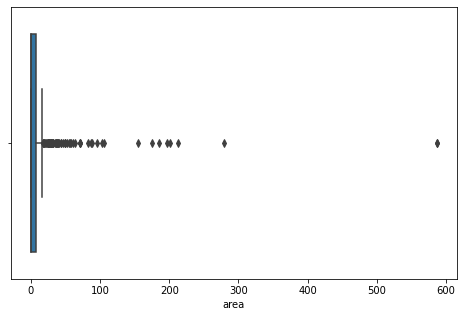

In [29]:
plt.figure(figsize=(8,5))
sns.boxplot(df.area)
plt.show()

In [25]:
uv=np.percentile(df.area, [99])[0]

In [28]:
df[df.area>uv]

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
235,91.4,142.4,601.4,10.6,19.6,41,5.8,0.0,196.4800,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,large
236,92.5,121.1,674.4,8.6,18.2,46,1.8,0.0,200.9400,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,large
237,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.8800,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,large
238,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,586.8672,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,large
415,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,586.8672,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,large
479,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.5300,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,large


In [31]:
df.area[df.area>3*uv]=3*uv

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509 entries, 0 to 516
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FFMC           509 non-null    float64
 1   DMC            509 non-null    float64
 2   DC             509 non-null    float64
 3   ISI            509 non-null    float64
 4   temp           509 non-null    float64
 5   RH             509 non-null    int64  
 6   wind           509 non-null    float64
 7   rain           509 non-null    float64
 8   area           509 non-null    float64
 9   dayfri         509 non-null    int64  
 10  daymon         509 non-null    int64  
 11  daysat         509 non-null    int64  
 12  daysun         509 non-null    int64  
 13  daythu         509 non-null    int64  
 14  daytue         509 non-null    int64  
 15  daywed         509 non-null    int64  
 16  monthapr       509 non-null    int64  
 17  monthaug       509 non-null    int64  
 18  monthdec  

In [33]:
df.iloc[:,0:9].corr()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
FFMC,1.000000,0.382925,0.331956,0.531926,0.431744,-0.306262,-0.030409,0.052280,0.045294
DMC,0.382925,1.000000,0.681446,0.309459,0.470875,0.062772,-0.104563,0.071017,0.092772
DC,0.331956,0.681446,1.000000,0.229757,0.496608,-0.047971,-0.202856,0.033772,0.057442
ISI,0.531926,0.309459,0.229757,1.000000,0.395858,-0.135955,0.104834,0.062132,0.006572
temp,0.431744,0.470875,0.496608,0.395858,1.000000,-0.532503,-0.227754,0.067911,0.106516
RH,-0.306262,0.062772,-0.047971,-0.135955,-0.532503,1.000000,0.070721,0.094343,-0.074967
wind,-0.030409,-0.104563,-0.202856,0.104834,-0.227754,0.070721,1.000000,0.059332,0.014554
rain,0.052280,0.071017,0.033772,0.062132,0.067911,0.094343,0.059332,1.000000,-0.007211
area,0.045294,0.092772,0.057442,0.006572,0.106516,-0.074967,0.014554,-0.007211,1.000000


In [41]:
df.size_category.value_counts()

small    371
large    138
Name: size_category, dtype: int64

In [39]:
lr=LabelEncoder()

In [42]:
df.size_category=lr.fit_transform(df.size_category)

In [44]:
df.size_category.value_counts()

1    371
0    138
Name: size_category, dtype: int64

In [45]:
df.shape

(509, 29)

In [48]:
X=df.iloc[:,df.columns != "size_category"]
y=df['size_category']

In [49]:
X.head(2)

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [52]:
X=MinMaxScaler().fit_transform(X)

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)

In [55]:
model = Sequential()
model.add(Dense(12, input_dim=28, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [56]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
model.fit(X_train, y_train, epochs=150, batch_size=10)

Epoch 1/150
41/41 [==============================] - 1s 2ms/step - loss: 0.7219 - accuracy: 0.3759
Epoch 2/150
41/41 [==============================] - 0s 2ms/step - loss: 0.6601 - accuracy: 0.7322
Epoch 3/150
41/41 [==============================] - 0s 1ms/step - loss: 0.6221 - accuracy: 0.7273
Epoch 4/150
41/41 [==============================] - 0s 2ms/step - loss: 0.5967 - accuracy: 0.7297
Epoch 5/150
41/41 [==============================] - 0s 2ms/step - loss: 0.5855 - accuracy: 0.7297
Epoch 6/150
41/41 [==============================] - 0s 1ms/step - loss: 0.5804 - accuracy: 0.7297
Epoch 7/150
41/41 [==============================] - 0s 2ms/step - loss: 0.5770 - accuracy: 0.7297
Epoch 8/150
41/41 [==============================] - 0s 1ms/step - loss: 0.5746 - accuracy: 0.7297
Epoch 9/150
41/41 [==============================] - 0s 1ms/step - loss: 0.5713 - accuracy: 0.7297
Epoch 10/150
41/41 [==============================] - 0s 1ms/step - loss: 0.5694 - accuracy: 0.7297
Epoch 11/

In [61]:
(_,accuracy)=model.evaluate(X_train, y_train)

13/13 [==============================] - 0s 2ms/step - loss: 0.0813 - accuracy: 0.9705


In [62]:
accuracy

0.9705159664154053

In [63]:
y_pred=model.predict(X_test)

In [70]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.2904 - accuracy: 0.8824


[0.29038503766059875, 0.8823529481887817]